# Предобработка данных

Прежде чем мы перейдем к обучению моделей нам необходимо выполнить преобразование исходных данных в удобный для использования вид

In [1]:
%matplotlib inline
import csv
import numpy as np
from scipy.sparse import *
from scipy import *


def read_raw_data():
    with open('dataset_for_candidates (2).tsv', newline='') as data_file:
        reader = csv.reader(data_file, delimiter='\t')
        return [row for row in reader]

In [2]:
raw_data = read_raw_data()

In [3]:
def get_feature_name(kv_str):
    return kv_str.split('#')[0]

def get_feature_value(kv_str):
    return kv_str.split('#')[1]

In [4]:
sex_labels_to_y = {'female':0, 'male':1}

Y_sex = np.array([sex_labels_to_y[get_feature_name(row[1])] for row in raw_data])

```python
print(len(feature_names))
print(np.mean([len(row)-2 for row in raw_data]))
```
233484
162.899673333

очень разреженные данные

Мы хотим преобразовать исходные данные в формат ```csr_matrix```, для этого мы
извлекаем из данных названия всех фичей и создаем отображение из названия фичи в целое число

In [5]:
def csr_matrix_from_raw_data(raw_data):
    feature_names = set([get_feature_name(key_value) for row in raw_data for key_value in row[2:]])
    fnames_to_i = dict(zip(list(feature_names), range(len(feature_names))))
    
    row = [ [i] * (len(raw_row) - 2) for (i,raw_row) in zip(range(len(raw_data)), raw_data) ]
    row = np.array([i for r in row for i in r])

    col = np.array([ fnames_to_i[get_feature_name(kv)] for row in raw_data for kv in row[2:] ])

    flatten_data = np.array([float(get_feature_value(kv)) for row in raw_data for kv in row[2:]])
    
    return csr_matrix( (flatten_data, (row,col)) )

In [6]:
X = csr_matrix_from_raw_data(raw_data)

# Предсказание пола

Для того, чтобы решить для себя какую метрику качества разумно использовать в данном случае, посмотрим на пропорции разных классов в наших данных.

Мы видим, что пропорции классов не равны, поэтому мы будем использовать ```AUC PR```, а не, например, ```accuracy```.

По этой же самой причине при разбиении данных на ```train``` и ```test``` мы будем использовать стратифицированное разбиение для того, чтобы в данных ```test``` пропорции классов совпадали с пропорциями в ```train```.

In [7]:
P = sum(Y_sex)
N = len(Y_sex) - P
print (P, N, P/N)

57302 92698 0.618157889059


In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y_sex,
                                                    stratify=Y_sex, 
                                                    test_size=0.2, 
                                                    random_state=42)

In [8]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt


def AUC_PR(score_fun, X=X_test, y=y_test, show_curve=False):
    y_score = score_fun(X)
    average_precision = average_precision_score(y, y_score)

    if show_curve:
        precision, recall, _ = precision_recall_curve(y, y_score)

        plt.step(recall, precision, color='b', alpha=0.2,
                 where='post')
        plt.fill_between(recall, precision, step='post', alpha=0.2,
                         color='b')

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title('2-class Precision-Recall curve: AUC={0:0.2f}'.format(
                  average_precision))
    
    return average_precision

Рассмотрим три базовые модели, на которые мы будем далее опираться и которые будем улучшать.

## Модель 1
### Логистическая регрессия

In [9]:
from sklearn import linear_model


def model1(params, X=X_train, y=y_train):
    logreg_clf = linear_model.LogisticRegression(**params)
    logreg_clf.fit(X, y)
    
    return logreg_clf

In [14]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params)
print(AUC_PR(clf1.decision_function))

0.631858542444


### Логистическая регрессия с $L_1$ регуляризатором

In [15]:
params = {
    'random_state':42,
    'penalty':'l1'
}

clf1 = model1(params)
print(AUC_PR(clf1.decision_function))

0.581064525315


Результаты не очень хорошие, поэтому далее мы не будем использовать данную модель.

## Модель 2
### SVM

Время обучения ```SVM``` значительно больше, чем время обучения логистической регрессии при этом результаты хуже.

In [16]:
from sklearn import svm


def model2(params, X=X_train, y=y_train):
    svc_clf = svm.SVC(**params)
    svc_clf.fit(X, y)

    return svc_clf

In [14]:
params = {
    
}

clf2 = model2(params)
print(AUC_PR(clf2.decision_function))

0.618983912012


## Модель 3
### Градиентный Бустинг

In [10]:
import xgboost as xgb


def model3(params,X=X_train, y=y_train):
    xgb_clf = xgb.XGBClassifier(**params)
    xgb_clf.fit(X, y)
    
    return xgb_clf

In [24]:
params = {
    
}

clf3 = model3(params)

In [34]:
def prob(X, clf):
    return clf.predict_proba(X)[:,1]

print(AUC_PR(lambda X: prob(X, clf3)))

0.697585181374


Мы обучили три модели на необработанных данных. Ниже приведена таблица со значением метрики для каждой модели:

| LogReg | SVM   | XGB   |
|------|------|------|
|   0.63  | 0.62| 0.70|

Мы могли бы попробовать использовать и другие методы обучения, но не будем этого делать.

## Scaling

Мы знаем, что в ряде случаев методы работают лучше, если предварительно был выполнен ```scaling``` данных.
Поэтому мы выполним данное преобразование, которое не приведет к нарушению разреженности в данных.

In [11]:
from sklearn.preprocessing import maxabs_scale


X_train_scaled = maxabs_scale(X_train, copy=True)
X_test_scaled = maxabs_scale(X_test, copy=True)

После того как мы выполнили масштабирование данных, мы можем попробовать обучить на них модели, о которых мы говорили ранее, например, логистическую регрессию.

### Модель 1.2

Как видно из результатов, данный классификатор лучше предыдущего.

In [32]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params, X=X_train_scaled)
print(AUC_PR(clf1.decision_function, X=X_test_scaled))

0.672745791493


### Модель 2.2

In [33]:
from sklearn.calibration import CalibratedClassifierCV


def model2_2(params, X=X_train, y=y_train):
    l_svc = svm.LinearSVC(**params)
    clf = CalibratedClassifierCV(l_svc) 
    clf.fit(X, y)
    
    return clf

In [35]:
clf2 = model2_2({}, X=X_train_scaled)

In [36]:
print(AUC_PR(lambda X: prob(X, clf2), X=X_test_scaled))

0.647538681012


### Модель 3.2

In [38]:
clf3 = model3({}, X_train_scaled)
print(AUC_PR(lambda X: prob(X, clf3), X=X_test_scaled))

0.696943773834


Результаты тестирования при обучении на масштабированных данных:

| LogReg | SVM   | XGB   |
|------|------|------|
|   0.67  | 0.65| 0.70|

Сравнивая данную таблицу с предыдущей можно сказать, что ```scaling``` положительно повлиял на логистическую регрессию, но не оказал влияния на градиентный бустинг.

## Aggregation

Из описания данных мы можем видеть, что тематические фичи описывают то, как сильно пользователь заинтерисован в той или иной тематики, и тематики образуют таксономии. 

Возможно, имеет смысл  агрегировать информацию о заинтерисованости пользователя в тематиках из одной и той же таксономии. Это как минимум позволит уменьшить размерность данных.

In [39]:
thematic_names = set([get_feature_name(key_value) 
                     for row in raw_data for key_value in row[2:] if key_value.startswith('thematic')]
                   )

In [40]:
print(len(thematic_names))

4052


In [41]:
def get_taxonomy_name(tn):
    return get_feature_name(tn).split('_')[0]

taxonomy_names = set([ get_taxonomy_name(tn) for tn in thematic_names])

In [42]:
print(taxonomy_names)

{'thematic21', 'thematic5', 'thematic1', 'thematic4', 'thematic0', 'thematic3', 'thematic6'}


Представленный ниже метод для трансформирования строк выполняет агрегацию информации для фичей из одной таксномии. Например, можно выполнять агрегацию вычисляя максимум или среднее арифмитическое.

In [43]:
def row_transform(row, aggregation_fn=max):
    r = []
    taxonomy_values = dict.fromkeys(taxonomy_names)
    for kv in row:
        if not kv.startswith('thematic'):
            r.append(kv)
        else:
            taxonomy = get_taxonomy_name(kv)
            if taxonomy_values.get(taxonomy, None) is None:
                taxonomy_values[taxonomy] = []
            taxonomy_values[taxonomy].append(float(get_feature_value(kv)))
    
    for (taxomony, values) in taxonomy_values.items():
        if values is not None:
            r.append(str(taxomony) + '#' + str(aggregation_fn(values)))
    
    return r

In [44]:
def raw_data_transform(raw_data):
    return [row_transform(row) for row in raw_data]

Строим новые данные для обучения и тестирования моделей

In [45]:
X_agg = csr_matrix_from_raw_data(raw_data_transform(raw_data))

In [46]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg, Y_sex, 
                                                                    stratify=Y_sex, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

### Модель 1.3

In [47]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params, X_train_agg, y_train_agg)
print(AUC_PR(clf1.decision_function, X_test_agg, y_test_agg))

0.626519473601


In [48]:
X_train_agg_scaled = maxabs_scale(X_train_agg, copy=True)
X_test_agg_scaled = maxabs_scale(X_test_agg, copy=True)

In [49]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params, X_train_agg_scaled, y_train_agg)
print(AUC_PR(clf1.decision_function, X_test_agg_scaled, y_test_agg))

0.650514072351


### Модель 2.3

In [50]:
clf2 = model2_2({}, X_train_agg_scaled, y_train_agg)
print(AUC_PR(lambda X: prob(X, clf2), X_test_agg_scaled, y_test_agg))

0.635549889895


### Модель 3.3

In [51]:
clf3 = model3({}, X_train_agg_scaled, y_train_agg)
print(AUC_PR(lambda X: prob(X, clf3), X_test_agg_scaled, y_test_agg))

0.663203094515


<b>Вывод:</b> смотря на результаты можно сказать, что получилось уменьшить размерность (пусть и незначительно), но с  потерями для качества классификации (XGB сильно потерял в качестве). Следовательно, подобный способ агрегации лучше не использовать.

## Outliers Detection

Попробуем обнаружить в данных выбросы (если они есть) и избавиться от них.

Для обнаружения выбросов будем использовать, например, ```IsolationForest```.

In [12]:
from sklearn.ensemble import IsolationForest


clf = IsolationForest(random_state=42)
clf.fit(X, Y_sex)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=42,
        verbose=0)

In [13]:
y_pred = clf.predict(X)

Посмотрим на долю выбросов в исходных данных. Классификатор говорит нам, что доля выбросов - 10%.

In [54]:
print(len(y_pred), len([_ for label in y_pred if label == -1]))

150000 15000


In [14]:
def raw_data_without_outliers(raw_data, y_pred):
    return [row for (row, inlier) in zip(raw_data, y_pred) if inlier == 1]

In [15]:
Y_sex_inliers = [sex for (sex, inlier) in zip(Y_sex, y_pred) if inlier == 1]

Новые данные без выбросов

In [16]:
X_inliers = csr_matrix_from_raw_data(raw_data_without_outliers(raw_data, y_pred))

In [17]:
X_train_in, X_test_in, y_train_in, y_test_in = train_test_split(X_inliers, Y_sex_inliers, 
                                                                    stratify=Y_sex_inliers, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

### Модель 1.4

In [59]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params, X_train_in, y_train_in)
print(AUC_PR(clf1.decision_function, X_test_in, y_test_in))

0.64024587942


In [18]:
X_train_in_scaled = maxabs_scale(X_train_in, copy=True)
X_test_in_scaled = maxabs_scale(X_test_in, copy=True)

In [61]:
params = {
    'random_state':42,
    'penalty':'l2'
}

clf1 = model1(params, X_train_in_scaled, y_train_in)
print(AUC_PR(clf1.decision_function, X_test_in_scaled, y_test_in))

0.669746064785


### Модель 2.4

In [62]:
clf2 = model2_2({}, X_train_in_scaled, y_train_in)
print(AUC_PR(lambda X: prob(X, clf2), X_test_in_scaled, y_test_in))

0.64085658352


### Модель 3.4

In [63]:
clf3 = model3({}, X_train_in_scaled, y_train_in)
print(AUC_PR(lambda X: prob(X, clf3), X_test_in_scaled, y_test_in))

0.68928802493


| LogReg | SVM   | XGB   |
|------|------|------|
|   0.67  | 0.64| 0.69|

<b>Вывод:</b> сравнивая таблицу результатов с таблицей из раздела ```Scaling``` видно, что поиск выбросов немного ухудшил качество предсказаний.

## Parameters Tuning

Попробуем выполнить оптимизацию гиперпараметров для классификаторов, которые будут обучаться на полученных ранее данных.

Для тюнинга гиперпараметров воспользуемся поиском по сетке.

In [19]:
from sklearn.model_selection import GridSearchCV


def auc_pr_score(estimator, X, y):
    return AUC_PR(lambda X: prob(X, estimator), X, y)
    
def GS(clf, p_grid, X=X_train_in_scaled, y=y_train_in):
    gsearch = GridSearchCV(estimator=clf, 
                           param_grid=p_grid, 
                           scoring=auc_pr_score, 
                           n_jobs=1, 
                           iid=False, 
                           cv=3, 
                           error_score=0)

    gsearch.fit(X, y)

    return gsearch.grid_scores_, gsearch.best_params_, gsearch.best_score_

### XGB
Займемся оптимизацией гиперпараметров для ```XGB``` классификатора. 

Для начала попробуем найти подходящее значение для параметра ```n_estimators```. 

In [68]:
param_grid1 = {
    'n_estimators':range(100,300,50)
}
    
gs, bp, bs = GS(xgb.XGBClassifier(random_state=42), param_grid1)
print(gs, bp, bs)

[mean: 0.69402, std: 0.00386, params: {'n_estimators': 100}, mean: 0.70212, std: 0.00369, params: {'n_estimators': 150}, mean: 0.70718, std: 0.00395, params: {'n_estimators': 200}, mean: 0.71088, std: 0.00413, params: {'n_estimators': 250}] {'n_estimators': 250} 0.71088109191


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [72]:
param_grid2 = {
    'max_depth':range(3,10,2),
    'min_child_weight':range(1,6,2)
}

gs, bp, bs = GS(xgb.XGBClassifier(random_state=42, n_estimators=250), param_grid2)
print(gs, bp, bs)

[mean: 0.71088, std: 0.00413, params: {'min_child_weight': 1, 'max_depth': 3}, mean: 0.71043, std: 0.00386, params: {'min_child_weight': 3, 'max_depth': 3}, mean: 0.71081, std: 0.00421, params: {'min_child_weight': 5, 'max_depth': 3}, mean: 0.71762, std: 0.00303, params: {'min_child_weight': 1, 'max_depth': 5}, mean: 0.71737, std: 0.00323, params: {'min_child_weight': 3, 'max_depth': 5}, mean: 0.71797, std: 0.00352, params: {'min_child_weight': 5, 'max_depth': 5}, mean: 0.72022, std: 0.00305, params: {'min_child_weight': 1, 'max_depth': 7}, mean: 0.71997, std: 0.00300, params: {'min_child_weight': 3, 'max_depth': 7}, mean: 0.72123, std: 0.00304, params: {'min_child_weight': 5, 'max_depth': 7}, mean: 0.72176, std: 0.00310, params: {'min_child_weight': 1, 'max_depth': 9}, mean: 0.72162, std: 0.00286, params: {'min_child_weight': 3, 'max_depth': 9}, mean: 0.72332, std: 0.00345, params: {'min_child_weight': 5, 'max_depth': 9}] {'min_child_weight': 5, 'max_depth': 9} 0.723318847435


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [73]:
param_grid3 = {
    'min_child_weight':[5,7,9]
}

gs, bp, bs = GS(xgb.XGBClassifier(random_state=42, n_estimators=250, max_depth=9), param_grid3)
print(gs, bp, bs)

[mean: 0.72332, std: 0.00345, params: {'min_child_weight': 5}, mean: 0.72269, std: 0.00323, params: {'min_child_weight': 7}, mean: 0.72349, std: 0.00401, params: {'min_child_weight': 9}] {'min_child_weight': 9} 0.723488825938


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [87]:
param_grid4 = {
    'subsample':[0.6, 0.7, 0.8, 0.9]
}

gs, bp, bs = GS(xgb.XGBClassifier(random_state=42, n_estimators=250, max_depth=9, min_child_weight=9), param_grid4)
print(gs, bp, bs)

/home/austud/anaconda3/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/home/austud/anaconda3/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/home/austud/anaconda3/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is deprecated.
  'seed is deprecated.', DeprecationWarning)
/home/austud/anaconda3/lib/python3.5/site-packages/xgboost-0.6-py3.5.egg/xgboost/sklearn.py:203: DeprecationWarning: The seed parameter is deprecated as of version .6.Please use random_state instead.seed is d

[mean: 0.72422, std: 0.00382, params: {'subsample': 0.6}, mean: 0.72413, std: 0.00365, params: {'subsample': 0.7}, mean: 0.72451, std: 0.00403, params: {'subsample': 0.8}, mean: 0.72407, std: 0.00346, params: {'subsample': 0.9}] {'subsample': 0.8} 0.72451005684


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [96]:
param_grid5 = {
    'colsample_bytree':[0.6, 0.7, 0.8, 0.9]
}

gs, bp, bs = GS(xgb.XGBClassifier(random_state=42, n_estimators=250, 
                                  max_depth=9, min_child_weight=9, subsample=0.8), param_grid5)
print(gs, bp, bs)

[mean: 0.72519, std: 0.00359, params: {'colsample_bytree': 0.6}, mean: 0.72487, std: 0.00370, params: {'colsample_bytree': 0.7}, mean: 0.72467, std: 0.00336, params: {'colsample_bytree': 0.8}, mean: 0.72447, std: 0.00318, params: {'colsample_bytree': 0.9}] {'colsample_bytree': 0.6} 0.725194074128


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Logistic Regression

Займемся теперь оптимизацией гиперпараметров для логистической регрессии.

In [75]:
param_grid1 = {
    'class_weight': ['balanced', None],
    'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
    
gs, bp, bs = GS(linear_model.LogisticRegression(random_state=42), param_grid1)
print(gs, bp, bs)

[mean: 0.60311, std: 0.00135, params: {'class_weight': 'balanced', 'C': 0.001}, mean: 0.61596, std: 0.00168, params: {'class_weight': None, 'C': 0.001}, mean: 0.64636, std: 0.00110, params: {'class_weight': 'balanced', 'C': 0.01}, mean: 0.64485, std: 0.00105, params: {'class_weight': None, 'C': 0.01}, mean: 0.67836, std: 0.00059, params: {'class_weight': 'balanced', 'C': 0.1}, mean: 0.67802, std: 0.00047, params: {'class_weight': None, 'C': 0.1}, mean: 0.67645, std: 0.00083, params: {'class_weight': 'balanced', 'C': 1}, mean: 0.67662, std: 0.00067, params: {'class_weight': None, 'C': 1}, mean: 0.64039, std: 0.00012, params: {'class_weight': 'balanced', 'C': 10}, mean: 0.64052, std: 0.00010, params: {'class_weight': None, 'C': 10}, mean: 0.59632, std: 0.00053, params: {'class_weight': 'balanced', 'C': 100}, mean: 0.59659, std: 0.00042, params: {'class_weight': None, 'C': 100}, mean: 0.56214, std: 0.00094, params: {'class_weight': 'balanced', 'C': 1000}, mean: 0.57296, std: 0.00321, para

/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


### Linear SVC

In [83]:
print(CalibratedClassifierCV(svm.LinearSVC(random_state=42)).get_params().keys())

dict_keys(['base_estimator__class_weight', 'base_estimator__multi_class', 'base_estimator__fit_intercept', 'base_estimator__dual', 'cv', 'method', 'base_estimator__verbose', 'base_estimator__max_iter', 'base_estimator', 'base_estimator__random_state', 'base_estimator__penalty', 'base_estimator__tol', 'base_estimator__C', 'base_estimator__intercept_scaling', 'base_estimator__loss'])


In [85]:
param_grid1 = {
    'base_estimator__class_weight': ['balanced', None],
    'base_estimator__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
    
gs, bp, bs = GS(CalibratedClassifierCV(svm.LinearSVC(random_state=42)), param_grid1)
print(gs, bp, bs) 

[mean: 0.63588, std: 0.00119, params: {'base_estimator__C': 0.001, 'base_estimator__class_weight': 'balanced'}, mean: 0.63295, std: 0.00117, params: {'base_estimator__C': 0.001, 'base_estimator__class_weight': None}, mean: 0.67292, std: 0.00049, params: {'base_estimator__C': 0.01, 'base_estimator__class_weight': 'balanced'}, mean: 0.67109, std: 0.00047, params: {'base_estimator__C': 0.01, 'base_estimator__class_weight': None}, mean: 0.68061, std: 0.00090, params: {'base_estimator__C': 0.1, 'base_estimator__class_weight': 'balanced'}, mean: 0.67940, std: 0.00053, params: {'base_estimator__C': 0.1, 'base_estimator__class_weight': None}, mean: 0.65222, std: 0.00049, params: {'base_estimator__C': 1, 'base_estimator__class_weight': 'balanced'}, mean: 0.65112, std: 0.00034, params: {'base_estimator__C': 1, 'base_estimator__class_weight': None}, mean: 0.61537, std: 0.00113, params: {'base_estimator__C': 10, 'base_estimator__class_weight': 'balanced'}, mean: 0.61487, std: 0.00099, params: {'ba

/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


В случае ```LinearSVC``` удалось добиться значительного улучшения качества предсказаний.

Ниже в таблице представлены значения для тюненых моделей:

| LogReg | SVM   | XGB   |
|------|------|------|
|   0.68  | 0.68| 0.73|

## Bagging

Попробуем построить классификатор, который будет представлять из себя взвешенное среднее построенных ранее моделей.

In [145]:
from sklearn.ensemble import VotingClassifier


logreg_params = {
    'random_state':42,
    'class_weight':'balanced', 
    'C':0.1
}

linsvc_params = {
    'random_state':42,
    'class_weight':'balanced', 
    'C':0.1
}

xgb_params = {
    'random_state':42,
    'n_estimators':250, 
    'max_depth':9,
    'min_child_weight':9,
    'subsample':0.8,
    'colsample_bytree':0.6
}

clf1 = linear_model.LogisticRegression(**logreg_params)
clf2 = CalibratedClassifierCV(svm.LinearSVC(**linsvc_params)) 
clf3 = xgb.XGBClassifier(**xgb_params)

eclf_params = {
    'estimators':[('lr', clf1), ('linsvc', clf2), ('xgb', clf3)],
    'voting':'soft'
}

eclf = VotingClassifier(**eclf_params)

Попробуем подобрать веса для классификаторов используя тюнинг гиперпараметров

In [141]:
param_grid1 = {
    'weights': [[1.0, 1.0 ,2.0], 
                [0.9, 1.0, 1.5], 
                [1.0, 0.9, 1.5], 
                None]
}
    
gs, bp, bs = GS(eclf, param_grid1)
print(gs, bp, bs) 

[mean: 0.72328, std: 0.00263, params: {'weights': [1.0, 1.0, 2.0]}, mean: 0.72157, std: 0.00248, params: {'weights': [0.9, 1.0, 1.5]}, mean: 0.72149, std: 0.00247, params: {'weights': [1.0, 0.9, 1.5]}, mean: 0.71691, std: 0.00215, params: {'weights': None}] {'weights': [1.0, 1.0, 2.0]} 0.723279694541


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [143]:
param_grid1 = {
    'weights': [[1.0, 1.0 ,3.0], 
                [0.9, 1.0, 4.0]]
}
    
gs, bp, bs = GS(eclf, param_grid1)
print(gs, bp, bs) 

[mean: 0.72531, std: 0.00283, params: {'weights': [1.0, 1.0, 3.0]}, mean: 0.72627, std: 0.00298, params: {'weights': [0.9, 1.0, 4.0]}] {'weights': [0.9, 1.0, 4.0]} 0.72627050899


/home/austud/.local/lib/python3.5/site-packages/sklearn/model_selection/_search.py:662: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [146]:
eclf_params['weights'] = [0.9, 1.0 ,4.0]

eclf = VotingClassifier(**eclf_params)

eclf.fit(X_train_in_scaled, y_train_in)
print(AUC_PR(lambda X: prob(X, eclf), X_test_in_scaled, y_test_in))

0.726016067314


In [147]:
eclf_params['weights'] = [1.0, 1.0 ,5.0]

eclf = VotingClassifier(**eclf_params)

eclf.fit(X_train_in_scaled, y_train_in)
print(AUC_PR(lambda X: prob(X, eclf), X_test_in_scaled, y_test_in))

0.726150712805


## Model Stacking

https://www.kaggle.com/arthurtok/introduction-to-ensembling-stacking-in-python

Попробуем использовать результаты предсказания предыдущих трех затюненых классификаторов как дополнительные фичи для нового классификатора.

Для этого построим новую матрицу, на которой будем выполнять обучение.

In [157]:
from sklearn.cross_validation import StratifiedKFold


ntrain = X_train_in_scaled.shape[0]
ntest = X_test_in_scaled.shape[0]

NFOLDS = 3 
y_train_in = np.array(y_train_in)
kf = StratifiedKFold(y_train_in, n_folds=NFOLDS, random_state=42)

In [158]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.fit(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [159]:
clf1_oof_train, clf1_oof_test = get_oof(clf1, X_train_in_scaled, y_train_in, X_test_in_scaled) # LogReg
clf2_oof_train, clf2_oof_test = get_oof(clf2, X_train_in_scaled, y_train_in, X_test_in_scaled) # LinearSVC
clf3_oof_train, clf3_oof_test = get_oof(clf3, X_train_in_scaled, y_train_in, X_test_in_scaled) # XGB 

In [160]:
x_train = np.concatenate(( clf1_oof_train, clf2_oof_train, clf3_oof_train), axis=1)
x_test = np.concatenate(( clf1_oof_test, clf2_oof_test, clf3_oof_test), axis=1)

In [161]:
gbm = xgb.XGBClassifier(random_state=42)
gbm.fit(x_train, y_train_in)
print(AUC_PR(lambda X: prob(X, gbm), x_test, y_test_in))

0.726837551117


Подводя итоги для задачи предсказания пола, рассмотрим таблицу со значением метрики ```AUC PR``` для различных моделей:

| LogReg | SVM   | XGB   | Bagging   | M.Stack.   |
|------|------|------|------|------|------|
|   0.68  | 0.68| 0.725| 0.726| 0.727|

Из таблицы видно, что наилучших результатов удалось добиться используя ```Stacking``` подход.

Кроме того, была выполнена попытка уменьшить размерность данных используя ```TruncatedSVD```, но доля объясненной дисперсии была слишком мала.

# Предсказание возраста

Попробуем решать задачу предсказания возраста как задачу классификации

In [20]:
age_labels = set([get_feature_name(row[0]) for row in raw_data])

print(age_labels)

{'age_25_34', 'age_45_54', 'age_35_44', 'age_55_64', 'age_65_plus', 'age_18_24'}


In [21]:
age_labels_to_y = {'age_18_24':0, 
                   'age_25_34':1, 
                   'age_35_44':2, 
                   'age_45_54':3, 
                   'age_55_64':4, 
                   'age_65_plus':5}

Y_age = np.array([age_labels_to_y[get_feature_name(row[0])] for row in raw_data])

Будем использовать данные очищенные от выбросов.

In [22]:
from sklearn.preprocessing import label_binarize


Y_age_inliers = [age for (age, inlier) in zip(Y_age, y_pred) if inlier == 1]

X_inliers_age = maxabs_scale(X_inliers, copy=True)

X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_inliers_age, Y_age_inliers, 
                                                                    stratify=Y_age_inliers, 
                                                                    test_size=0.2, 
                                                                    random_state=42)

y_test_age_bin = label_binarize(y_test_age, classes=range(6))

Посмотрим на пропрции классов в данных. Мы видим, что пропорции классов сильно отличаются.

In [23]:
weights = [y_train_age.count(i)/len(y_train_age) for i in range(6)]
print(weights)

[0.07624074074074073, 0.3360092592592593, 0.3052592592592593, 0.16687037037037036, 0.09760185185185186, 0.018018518518518517]


### Модель 1

In [200]:
clf = model1({'class_weight':'balanced', 'random_state':42}, X_train_age, y_train_age)

In [179]:
avg_prec = average_precision_score(y_test_age_bin, clf.decision_function(X_test_age), average="micro")
print(avg_prec)

0.346367354468


Так как классы упорядочены вдоль числовой прямой, то нас интересуют ошибки, связанные с тем, что объекты, лежащие рядом с границей класса, были отнесены классификатором к соседнему классу.

Для того, чтобы оценить качество классификатора, построим ```confusion matrix```.

In [24]:
import itertools
from sklearn.metrics import confusion_matrix

# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
class_names = ['age_18_24', 'age_25_34', 'age_35_44', 'age_45_54', 'age_55_64', 'age_65_plus']

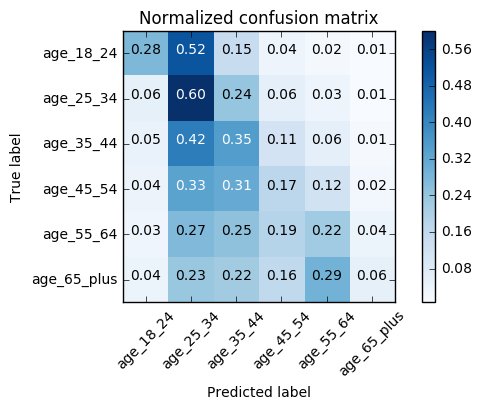

In [201]:
cnf_matrix = confusion_matrix(y_test_age, clf.predict(X_test_age))

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Смотря на таблицу, можно сказать, что, действительно, в среднем, количество объектов, которые были ошибочно классифицированы в другие классы, уменьшается с увеличением расстояния между истинным классом и ошибочным.

Так, например, 52% объектов класса ```age_18_24``` были ошибочно отнесены к классу ```age_25_34```, и к классу ```age_35_44``` были ошибочно отнесены 15% объектов.

### Модель 2

Обучим ```XGB``` классификатор.

In [202]:
clf = model3({'objective':'multi:softmax', 'random_state':42}, X_train_age, y_train_age)

In [30]:
def show_results(clf, X_test=X_test_age, y_test=y_test_age, y_test_bin=y_test_age_bin):
    avg_prec = average_precision_score(y_test_age_bin, clf.predict_proba(X_test_age), average="micro")
    print(avg_prec)

    cnf_matrix = confusion_matrix(y_test_age, clf.predict(X_test_age))

    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')

    plt.show()

0.406783415091


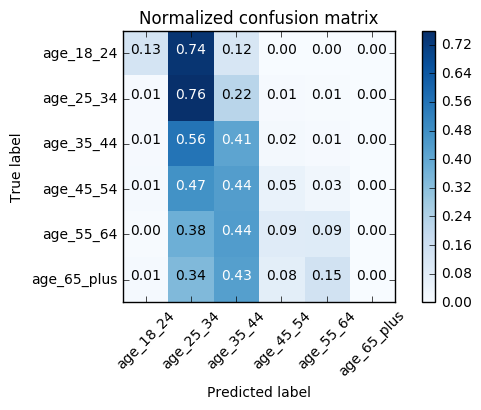

In [203]:
show_results(clf)

Можно видеть, что данный классификатор значительно лучше предыдущего.

### Модель 3

In [204]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(random_state=42, class_weight='balanced')
clf.fit(X_train_age, y_train_age)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_split=1e-07,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

0.321040169324


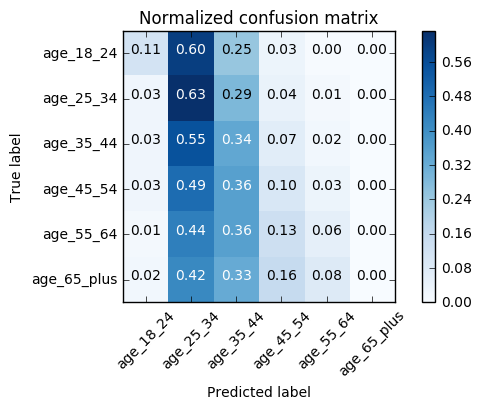

In [205]:
show_results(clf)

Для последних двух моделей верно, что в срднем, к какому бы классу на самом деле не принадлежал объект, он будет классифицирован как объект класса ```age_25_34``` или класса ```age_35_44```. 

Данное надлюдение наводит нас на мысль о том, что классификаторы не чувствительны к объектам из маленьких классов. 

Ниже мы попробуем решить данную проблему.

## Over-sampling

Мы знаем, что пропорции классов в данных сильно отличаются. Для того чтобы сделать классификатор более чувствительными к объектам принадлежащим маленьким классам выполним процедуру ```over-sampling'```а.

In [26]:
from imblearn.over_sampling import SMOTE


sm = SMOTE(random_state=42, ratio='minority', kind='svm')
x_train_res, y_train_res = sm.fit_sample(X_train_age, y_train_age)

In [27]:
weights_res = [list(y_train_res).count(i)/len(y_train_res) for i in range(6)]
print(weights)
print(weights_res)

[0.07624074074074073, 0.3360092592592593, 0.3052592592592593, 0.16687037037037036, 0.09760185185185186, 0.018018518518518517]
[0.06489238456264235, 0.2859946251389031, 0.2598217311466108, 0.14203188663929323, 0.08307391616162413, 0.1641854563509264]


In [28]:
clf = model3({'objective':'multi:softmax', 'random_state':42}, x_train_res, y_train_res)

0.403064267791


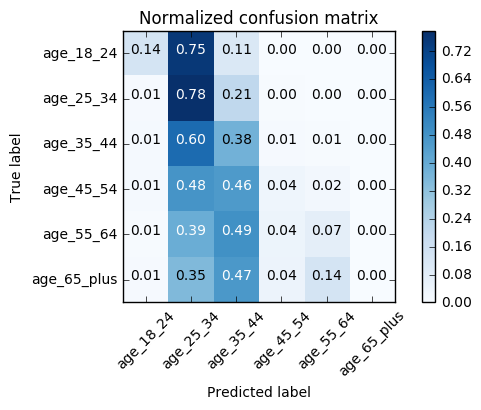

In [31]:
show_results(clf)

Сравнивая полученные результаты с ```confusion``` матрицой для модели 2 можно сказать, что не смотря на выполненную процедуру ```over-sampling'```а, класс ```age_65_plus``` выделяется классификатором все так же плохо.

Итоговая таблица ```AUC PR```:

| LogReg | XGB   | RF   | O.-S.   |
|------|------|------|------|
|   0.3463  | 0.4067| 0.3210| 0.4030|


### Возможные дальнейшие шаги

К сожелению, в связи с нехваткой времени, не удалось выполнить все интересующие эксперименты или попробовать другие методы обучения.

Возможные шаги:
- Попробовать другие методы для выполнения resampling'а
- Для решение описаной ранее проблемы можно было бы попробовать выполнить under-sampling для двух majority классов.
- Выполнить тюнинг параметров модели 2, так как она показала наилучший результат.